In [1]:
from cnn_globals import *

from cnn_data import cnn_data, cnn_data_split

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_1_7
[INFO    ] Using numpy 1.14.1
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs_depscipy/3.0-omkpbe5/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[INFO    ] Using tensorflow 1.5.0
[INFO    ] Using keras 2.1.2-tf
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.0.0
[INFO    ] Using sklearn 0.19.2


In [2]:
# Import images and labels
#data = cnn_data_split(infile_images, test_size=0.4, shuffle=False, nentries=40000)
data = cnn_data_split(infile_images, test_size=0.3, shuffle=False, nentries=3535500)

(images_px_train, images_px_test, images_ch_train, images_ch_test, labels_train, labels_test, parameters_train, parameters_test) = data

[INFO    ] Loading cnn data from ../test7/histos_tbe.17.npz ...
[INFO    ] Loaded the images with shape (3535956, 50, 2),(3535956, 50, 3)
[INFO    ] Loaded the labels with shape (3535956, 3)
[INFO    ] Loaded the parameters with shape (3535956, 4)
[INFO    ] Loaded # of training and testing events: (2474850, 1060650)


In [3]:
use_jupyter = True

use_keras = False

if use_keras:
  from cnn_keras import define_reiam_flags, run_reiam
else:
  from cnn_estimator import define_reiam_flags, run_reiam

In [4]:
#from absl import app
#from absl import flags
flags = tf.flags
app = tf.app

estimators = {}

def main(_):
  data = (images_px_train, images_px_test, images_ch_train, images_ch_test, labels_train, labels_test, parameters_train, parameters_test)
  reiam_classifier = run_reiam(flags.FLAGS, data)
  estimators['reiam_classifier'] = reiam_classifier

def run(main, argv=['lol']):
  if use_jupyter:
    argv = flags.FLAGS(argv)
    main(argv)
  else:
    app.run(main=main, argv=argv)

#tf.logging.set_verbosity(tf.logging.INFO)
define_reiam_flags()
run(main)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 1200, '_session_config': intra_op_parallelism_threads: 4
allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_tf_random_seed': 2023, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1c707b33d0>, '_model_dir': './reiam_model', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_save_summary_steps': 100, '_num_ps_replicas': 0}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./reiam_model/model.ckpt.
INFO:tensorflow:train_accuracy_at_k = 0.08, learning_rate = 0.001, cross_entropy = 3.0448046, train_accuracy = 0.08
INFO:tensorflow:Saving timeline for 1 into './reiam_model/timeline-1.json'.
INFO:tensorflow:loss = 3.0448046, step = 1
INFO:tensorflow:global_step/sec: 7.44413
INFO:tensorflo

In [5]:
from cnn_keras import parse_image_fn, parse_label_fn, rows_per_zone
flags_obj = tf.flags.FLAGS

nentries_test = 40000

images_px_test = images_px_test[:nentries_test]
images_ch_test = images_ch_test[:nentries_test]
labels_test = labels_test[:nentries_test]

images = map(lambda (px, ch): parse_image_fn(px, ch), zip(images_px_test, images_ch_test))
labels = map(lambda lb: parse_label_fn(lb), labels_test)
images = np.asarray(images)
labels = np.asarray(labels)

In [6]:
from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'rows_per_zone': rows_per_zone})

from nn_models import load_my_model
loaded_model = load_my_model(name='model_cnn', weights_name='model_cnn_weights')

labels_pred = loaded_model.predict(images, batch_size=flags_obj.batch_size)

In [7]:
from sklearn.metrics import r2_score
labels_1 = np.argmax(labels,axis=1)
labels_pred_1 = np.argmax(labels_pred,axis=1)
r2_score(labels_1, labels_pred_1)

0.9682626865317946

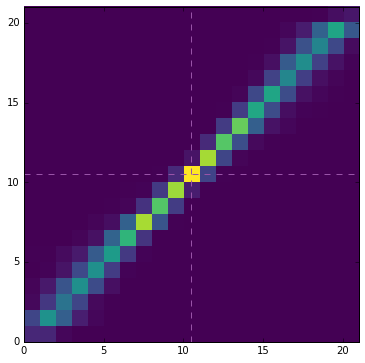

In [8]:
plt.figure(figsize=(6,6))
plt.axvline(x=10.5, linewidth=1, linestyle='--', color='#9954A8')
plt.axhline(y=10.5, linewidth=1, linestyle='--', color='#9954A8')
hist, xedges, yedges, _ = plt.hist2d(labels_1, labels_pred_1, bins=(21,21), range=((0,21),(0,21)), cmap=plt.cm.viridis)
plt.show()